In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler
# %config Completer.use_jedi = False

In [2]:
import os
import sys
module_path = "/Users/jmccarty/Data/221205_ipv_workbench/github/IPV_Workbench"
sys.path.insert(0, module_path)
import pandas as pd
import pickle
import json
from itertools import repeat
import multiprocess
from pprint import pprint
import numpy as np
import pvlib
import proplot as pplt
import ipv_workbench as ipv
from ipv_workbench.utilities import utils, circuits, time_utils
from ipv_workbench.devices import devices
from ipv_workbench.simulator import simulations as ipv_sim
from ipv_workbench.simulator import simulations_mp as ipv_sim_mp
from ipv_workbench.simulator import calculations as ipv_calc
from ipv_workbench.visualize import plots as ipv_plots
from ipv_workbench.translators import panelizer
from ipv_workbench.sample import dummies
from tqdm import tqdm
import functools, operator, collections
import multiprocess as mp
import time

In [ ]:
import itertools
import math
# for i in range(0,6):
#     module_irrad.append()
#     for j in range(0,20):
#         module_irrad.append([0] * 8760)

 
def create_repeating_list(n_int, n_repeat):
    lst = range(0,n_int)
    return list(itertools.chain.from_iterable(itertools.repeat(x, n_repeat) for x in lst))


def flatten_list(lst):
    return [j for i in lst for j in i]

def generate_submodule_arrays(n_cols=6, n_rows=20, template = "1A", n_diodes=3, n_submodules=3, diode_placement='columns'):
    if diode_placement=='columns':
        if n_cols<=n_rows:
            n_diodes_repeat = int(math.floor(n_cols / n_diodes))
        else:
            n_diodes_repeat = int(math.floor(n_rows / n_diodes))
    elif diode_placement=='rows':
        if n_cols<=n_rows:
            n_diodes_repeat = int(math.floor(n_rows / n_diodes))
        else:
            n_diodes_repeat = int(math.floor(n_cols / n_diodes))
        
    
    if template=="1A":
        # this is a standard template for a crystalline, meant for a 3 diode module where every 2 cols are on their own diode 
        if n_cols<=n_rows:
            row  = [[0]*n_cols]
            submodule_array = row*n_rows

            row = [create_repeating_list(n_diodes,n_diodes_repeat)]
            subdiode_array = row*n_rows

            
        else:
            n_diodes_repeat = int(n_rows / n_diodes)

            row = [[0]*n_cols]
            submodule_array = row*n_rows
            
            switch = n_rows / n_diodes
            subdiode_array = []
            for n in range(0, n_diodes):
                for r in range(0,n_diodes_repeat):
                    row = [n]*n_cols
                    subdiode_array.append(row)
                    
    elif template=="1B":
        # this is a standard template for a half cut module, meant for a 3 diode module where every 2 cols are on their own diode 
        if n_cols<=n_rows:
            n_diodes_repeat = int(n_cols / n_diodes)

            submodule_array = []
            for submodule_n in range(0,n_submodules):
                row  = [[submodule_n]*n_cols]
                submodule_array.append(row*int(n_rows/n_submodules))
            submodule_array = flatten_list(submodule_array)

            subdiode_array = []
            for submodule_n in range(0,n_submodules):
                row = [create_repeating_list(n_diodes,n_diodes_repeat)]
                subdiode_array.append(row*int(n_rows/n_submodules))
            subdiode_array = flatten_list(subdiode_array)

        else:
            
            n_diodes_repeat = int(n_rows / n_diodes)

            row = flatten_list([[submodule_n] * int(n_cols/n_submodules) for submodule_n in range(0,n_submodules)])
            submodule_array = [row]*n_rows

            subdiode_array = []
            for diode in list(reversed(create_repeating_list(n_diodes,n_diodes_repeat))):
                row = [diode] * n_cols
                subdiode_array.append(row)
    
    # check row length
    if len(submodule_array)<len(subdiode_array):
        # just shorten b
        subdiode_array = subdiode_array[:len(submodule_array)]
    elif len(submodule_array)>len(subdiode_array):
        # extend and then shorten
        print("not tall enough")
        missing = len(submodule_array) - len(subdiode_array)
        subdiode_array = utils.flatten_list([subdiode_array]*(missing+1))[:len(submodule_array)]
        subdiode_array = subdiode_array[-1:] + subdiode_array[:-1]

    # check column length
    if len(submodule_array[0])<len(subdiode_array[0]):
        subdiode_array = [subdiode_array[:len(submodule_array[0])] for b_ in b]
    elif len(submodule_array[0])>len(subdiode_array[0]):
        missing = len(submodule_array[0]) - len(subdiode_array[0])
        subdiode_array_new = []
        for subdiode_array_ in subdiode_array:
            subdiode_array_new_sub = utils.flatten_list([b_]*(missing+1))[:len(submodule_array[0])]
            subdiode_array_new_sub.sort()
            subdiode_array_new.append(subdiode_array_new_sub)
        subdiode_array = subdiode_array_new
    
    ### check again as last effort and if problem than clear diodes
    if len(submodule_array)!=len(subdiode_array):
        # copy submodule_array but as zeros
        subdiode_array = [[0*x for x in L] for L in submodule_array]
    
    
    
    return submodule_array, subdiode_array

n_cols=4
n_rows=112
n_cells = n_cols*n_rows
template = "1A"
n_diodes = 56

if n_diodes==None:
    if n_cells <= 40:
        n_diodes=1
    elif (n_cells>40) & (n_cells<100):
        n_diodes=2
    else:
        n_diodes=3
else:
    pass

n_submodules=1



    
a,b = generate_submodule_arrays(n_cols=n_cols, n_rows=n_rows, template=template, n_diodes=n_diodes, n_submodules=n_submodules, diode_placement='rows')

b[0][0]
# 

In [867]:
subcell_array = []

n_subcells = 4
n_cols = 4
n_rows = 112

for subcell in range(0,n_subcells):
    row  = [list(range(0,n_subcells))]
    subcell_array.append(row*int(n_rows/n_subcells))
subcell_array = flatten_list(subcell_array)

print(np.array(subcell_array).shape)
subcell_array

(112, 4)


[[0, 1, 2, 3],
 [0, 1, 2, 3],
 [0, 1, 2, 3],
 [0, 1, 2, 3],
 [0, 1, 2, 3],
 [0, 1, 2, 3],
 [0, 1, 2, 3],
 [0, 1, 2, 3],
 [0, 1, 2, 3],
 [0, 1, 2, 3],
 [0, 1, 2, 3],
 [0, 1, 2, 3],
 [0, 1, 2, 3],
 [0, 1, 2, 3],
 [0, 1, 2, 3],
 [0, 1, 2, 3],
 [0, 1, 2, 3],
 [0, 1, 2, 3],
 [0, 1, 2, 3],
 [0, 1, 2, 3],
 [0, 1, 2, 3],
 [0, 1, 2, 3],
 [0, 1, 2, 3],
 [0, 1, 2, 3],
 [0, 1, 2, 3],
 [0, 1, 2, 3],
 [0, 1, 2, 3],
 [0, 1, 2, 3],
 [0, 1, 2, 3],
 [0, 1, 2, 3],
 [0, 1, 2, 3],
 [0, 1, 2, 3],
 [0, 1, 2, 3],
 [0, 1, 2, 3],
 [0, 1, 2, 3],
 [0, 1, 2, 3],
 [0, 1, 2, 3],
 [0, 1, 2, 3],
 [0, 1, 2, 3],
 [0, 1, 2, 3],
 [0, 1, 2, 3],
 [0, 1, 2, 3],
 [0, 1, 2, 3],
 [0, 1, 2, 3],
 [0, 1, 2, 3],
 [0, 1, 2, 3],
 [0, 1, 2, 3],
 [0, 1, 2, 3],
 [0, 1, 2, 3],
 [0, 1, 2, 3],
 [0, 1, 2, 3],
 [0, 1, 2, 3],
 [0, 1, 2, 3],
 [0, 1, 2, 3],
 [0, 1, 2, 3],
 [0, 1, 2, 3],
 [0, 1, 2, 3],
 [0, 1, 2, 3],
 [0, 1, 2, 3],
 [0, 1, 2, 3],
 [0, 1, 2, 3],
 [0, 1, 2, 3],
 [0, 1, 2, 3],
 [0, 1, 2, 3],
 [0, 1, 2, 3],
 [0, 1, 2, 3],
 [0, 1, 2,

In [120]:
dummies.generate_sample_module_maps(n_rows=6, n_cols=20, module_template="a2")

(array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
 array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]]))

In [5]:
## Create Ccll
file_p = "/Users/jmccarty/Data/221205_ipv_workbench/github/IPV_Workbench/ipv_workbench/devices/default_devices/cell_parameters_default_monocrystalline.txt"
my_cell = devices.Cell(file_p)
iv_library_name = "/Users/jmccarty/Data/220723_iv_library/library/test_cell/test_gzip.gz"
my_cell.assign_iv_library(iv_library_name)

In [39]:
## Build up dummy object
n_srfs = 2
n_series = 4
n_modules = 12

sample_dict = dummies.generate_sample_building_dict(n_srfs, n_series, n_modules)
po = panelizer.PanelizedObject(sample_dict)
po.cell = my_cell

## Load weather data
tmy_file = "/Users/jmccarty/Data/221205_ipv_workbench/github/IPV_Workbench/ipv_workbench/sample/zurich_2007_2021.epw"
po.tmy_dataframe = utils.tmy_to_dataframe(tmy_file)

In [ ]:
####### start simulation within loop #######
def simulate_system(po, surface, hoy):
    
    if po.topology == 'central_inverter':
        ipv_sim.simulation_central_inverter(
            po, surface, hoy)
    elif po.topology == 'string_inverter':
        ipv_sim.simulation_string_inverter(
            po, surface, hoy)
    elif po.topology == 'micro_inverter':
        ipv_sim.simulation_micro_inverter(
            po, surface, hoy)

####### write results for string inverter #######
def write_string_inverter(po, surface, hoy):
    
    # TODO the initial write can be done during the simulation
    
    # get the strings
    strings = po.get_strings(surface)

    # break out the results dict into individual lists
    # i_list = results_dict[hoy][0]
    # v_list = results_dict[hoy][1]
    # g_list = results_dict[hoy][2]
    i_list = [po.get_dict_instance([surface, string])['CURVES'][po.topology]['Istr'][hoy] for string in po.get_strings(surface)]
    v_list = [po.get_dict_instance([surface, string])['CURVES'][po.topology]['Vstr'][hoy] for string in po.get_strings(surface)]
    g_list = [po.get_dict_instance([surface, string])['YIELD'][po.topology]['irrad'][hoy] for string in po.get_strings(surface)]

    # this loops through each "string" in the results
    for n in range(0, len(i_list)):

        # get the result keys from the string level
        string_result_keys = list(po.get_dict_instance([surface, strings[n]])[
                                  'YIELD'][po.topology].keys())

        # calculate mpp and related ->  [Imp, Vmp, Pmp, Isc, Voc, FF]
        # store in a temp directory
        simulation_results_string = ipv_sim.calcMPP_IscVocFF(np.array(i_list[n]),
                                                             np.array(v_list[n]))
        temp_results_dict = utils.generate_empty_results_dict(
            target='STRING')
        temp_results_dict.update(simulation_results_string)
        temp_results_dict.update({'irrad': g_list[n]})

        # store everything in a dict
        if g_list[n] == 0:
            temp_results_dict.update({'eff': 0})
        else:
            efficiency = temp_results_dict['pmp'] / temp_results_dict['irrad']
            temp_results_dict.update({'eff': efficiency})

        # iterate over the result keys and write then to the panelizer object
        for key in string_result_keys:
            # write to the panelizer object at the string level
            po.get_dict_instance([surface, strings[n]])[
                'YIELD'][po.topology][key].update({hoy: np.round(temp_results_dict[key], 3)})

        # get the current at maximum power point to send to the module to calculate the power at MPP on the module
        operating_imp = np.round(temp_results_dict['imp'], 3)

        # loop through all modules in the string to calculate the power of the module using imp
        # then write this and then calculat ethe efficiency using the svaed irrad
        for module in po.get_modules(surface, strings[n]):

            Imod_hoy = po.get_dict_instance(
                [surface, strings[n], module])['CURVES'][po.topology]['Imod'][hoy]
            Vmod_hoy = po.get_dict_instance(
                [surface, strings[n], module])['CURVES'][po.topology]['Vmod'][hoy]

            # interp the relationship between I and V for the hour o the module using the oeprating I
            operating_vmp = np.round(np.interp(operating_imp, np.flipud(Imod_hoy),
                                               np.flipud(Vmod_hoy)), 5)
            module_input_energy = po.get_dict_instance([surface, strings[n], module])[
                'YIELD'][po.topology]['irrad'][hoy]
            module_mpp_power = np.round(operating_vmp * operating_imp, 3)
            if module_input_energy == 0:
                module_eff = 0
            else:
                module_eff = np.round(
                    module_mpp_power / module_input_energy, 3)

            # write these results to the module dict
            po.get_dict_instance([surface, strings[n], module])[
                'YIELD'][po.topology]['imp'].update({hoy: operating_imp})
            po.get_dict_instance([surface, strings[n], module])[
                'YIELD'][po.topology]['vmp'].update({hoy: operating_vmp})
            po.get_dict_instance([surface, strings[n], module])[
                'YIELD'][po.topology]['pmp'].update({hoy: module_mpp_power})
            po.get_dict_instance([surface, strings[n], module])[
                'YIELD'][po.topology]['eff'].update({hoy: module_eff})

####### write string results #######
def write_up_string_results(po, surface, string):
    string_dict = po.get_dict_instance([surface, string])['YIELD'][po.topology]

    sub_dict = po.get_dict_instance([surface, string])['MODULES']

    for key in string_dict.keys():
        key_result = utils.gather_sublevel_results(po,
                                    sub_dict,
                                    po.get_modules(surface,string),
                                    key)
        string_dict[key].update(key_result)
        
    # recalculate efficiency
    for hoy_n, hoy in enumerate(range(0, 24)):
        string_power = string_dict['pmp'][hoy]
        string_irrad = string_dict['irrad'][hoy]
        if string_irrad == 0:
            string_efficiency = 0
        else:
            string_efficiency = np.round(string_power / string_irrad, 3)
        string_dict['eff'][hoy] = string_efficiency


####### write surface results #######
def write_up_surface_results(po, surface):
    if po.topology=='central_inverter': 
        pass
    else:
        # set the surface dict to the results section
        surface_dict = po.get_dict_instance([surface])['YIELD'][po.topology]

        # get the dict at the surface level to write into
        surface_strings_dict = po.get_dict_instance([surface])['STRINGS']

        for key in surface_dict.keys():
            key_result = utils.gather_sublevel_results(po,
                                                    surface_strings_dict,
                                                    po.get_strings(surface),
                                                    key)
            surface_dict[key].update(key_result)

        # recalculate efficiency
        for hoy_n, hoy in enumerate(range(0, 24)):
            surface_power = surface_dict['pmp'][hoy]
            surface_irrad = surface_dict['irrad'][hoy]
            if surface_irrad == 0:
                surface_efficiency = 0
            else:
                surface_efficiency = np.round(surface_power / surface_irrad, 3)
            surface_dict['eff'][hoy] = surface_efficiency

####### write object results #######
def write_up_object_results(po):
    object_dict = po.panelizer_dict[po.object_type]['YIELD'][po.topology]

    for key in object_dict.keys():
        key_result = utils.gather_sublevel_results(po,
                                                   po.panelizer_dict[po.object_type]['SURFACES'],
                                                   po.get_surfaces(),
                                                   key)
        object_dict[key].update(key_result)

    # recalculate efficieny
    for hoy_n, hoy in enumerate(range(0, 24)):
        object_power = object_dict['pmp'][hoy]
        object_irrad = object_dict['irrad'][hoy]
        if object_irrad == 0:
            object_efficiency = 0
        else:
            object_efficiency = np.round(object_power / object_irrad, 3)
        object_dict['eff'][hoy] = object_efficiency


In [ ]:
po.topology = 'micro_inverter'


for surface in po.get_surfaces():
    po.reset_results_dict(surface)
    for hoy in tqdm(range(0,24)):
        simulate_system(po, surface, hoy)
        
        write_first_level_results(po, surface, hoy) # topology dependent
    
    for string in po.get_strings(surface):
        if po.topology=='micro_inverter':
            write_up_string_results(po, surface, string)

    write_up_surface_results(po, surface)

write_up_object_results(po)
    

In [42]:

po.ncpu = 6
po.set_analysis_period(0,100,1)
surface = po.get_surfaces()[0]
string = po.get_strings(surface)[0]
module = po.get_modules(surface,string)[0]

In [ ]:

for topology in ['string_inverter', 'micro_inverter', 'central_inverter']:
    print(topology)
    po.topology = topology
    for surface in po.get_surfaces():
        po.reset_results_dict(surface)
        for hoy in tqdm(range(0,8760)):
            po.simulate_system(surface, hoy)
            
            po.write_first_level_results(surface, hoy) # topology dependent
        
        for string in po.get_strings(surface):
            if po.topology=='micro_inverter':
                po.write_up_string_results(surface, string)

        po.write_up_surface_results(surface)

    po.write_up_object_results()

In [40]:
start = time.time()
po.ncpu = 6
po.set_analysis_period(0,1000,1)

#def simulation_suite

po.simulation_suite = True

print("Starting multi-topology simulation by initialising the module curves (topology independent)")
for surface in po.get_surfaces():
    print(surface)
    for string in po.get_strings(surface):
        print(f"--------------")
        print(f"    String {string}")
        print("    Simulating all module curves")
        ipv_sim_mp.run_mp_simulation(po, surface, string)

print("Conducting analysis for each topology using module curves.")
for topology in po.simulation_suite_topologies:
    print(f"    Starting {topology}")
    print("    Writing first level results for topologies")
    po.topology = topology
    for surface in po.get_surfaces():
        po.simulate_system_mp(surface)

        for hoy in tqdm(po.all_hoy):
            po.write_first_level_results(surface, hoy) 
        
        if po.topology=='micro_inverter':
            for string in po.get_strings(surface):
                po.write_up_string_results(surface, string)

        po.write_up_surface_results(surface)

    po.write_up_object_results()


end = time.time()
print(str(round(end-start,1))+" seconds")

Starting multi-topology simulation by initialising the module curves (topology independent)
Srf0
--------------
    String 0:0:0
    Simulating all module curves
    -----------
Time elapsed for string 0:0:0: 6.18s
--------------
    String 0:0:1
    Simulating all module curves
    -----------
Time elapsed for string 0:0:1: 19.09s
--------------
    String 0:0:2
    Simulating all module curves
    -----------
Time elapsed for string 0:0:2: 6.11s
--------------
    String 0:0:3
    Simulating all module curves
    -----------
Time elapsed for string 0:0:3: 5.96s
Srf1
--------------
    String 0:0:0
    Simulating all module curves
    -----------
Time elapsed for string 0:0:0: 6.01s
--------------
    String 0:0:1
    Simulating all module curves
    -----------
Time elapsed for string 0:0:1: 6.35s
--------------
    String 0:0:2
    Simulating all module curves
    -----------
Time elapsed for string 0:0:2: 6.37s
--------------
    String 0:0:3
    Simulating all module curves
    --

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1250.38it/s]


    Starting string_inverter
    Writing first level results for topologies


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1061.10it/s]


    Starting central_inverter
    Writing first level results for topologies


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1020.47it/s]

71.9 seconds


In [9]:
hoy = 12
surface = po.get_surfaces()[0]
string = po.get_strings(surface)[0]
module = po.get_modules(surface,string)[0]


Imod_hoy = po.get_dict_instance([surface, string, module])['CURVES']['initial_simulation']['Imod'][hoy]
Vmod_hoy = po.get_dict_instance([surface, string, module])['CURVES']['initial_simulation']['Vmod'][hoy]

# interp the relationship between I and V for the hour on the module using the operating V from
# the central inverter

operating_vmp = po.get_dict_instance([surface])['YIELD']['central_inverter']['vmp'][hoy]
operating_imp = np.round(np.interp(operating_vmp, np.flipud(Vmod_hoy),
                                                       np.flipud(Imod_hoy)), 5)

module_input_energy = po.get_dict_instance([surface, string, module])['YIELD']['initial_simulation']['irrad'][hoy]
module_mpp_power = np.round(operating_vmp * operating_imp, 3)
if module_input_energy == 0:
    module_eff = 0
else:
    module_eff = np.round(
        module_mpp_power / module_input_energy, 3)
    
(operating_imp,operating_vmp)


(0.84819, 957.065)

In [85]:
Imod_hoy[0] < Imod_hoy[-1]

False

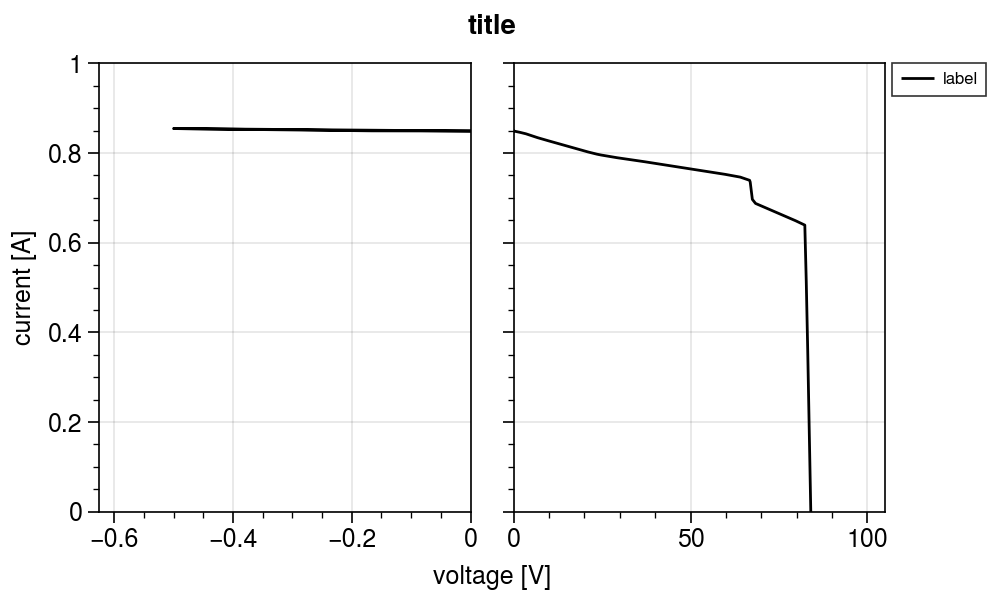

In [89]:
ipv_plots.plot_curves(Imod_hoy,Vmod_hoy,my_cell.parameters_dict,y_max=1)

In [30]:
surface = po.get_surfaces()[1]
string = po.get_strings(surface)[3]
module = po.get_modules(surface,string)[3]



po.get_tabular_results([surface, string],topology='central_inverter')

,Current at MPPT (amperes),Voltage at MPPT (volt),Power at MPPT (W),Irradiance (W),Efficiency (%)
2023-01-01 00:00:00,0.00000,0.00000,0.000,0.0,0.000
2023-01-01 01:00:00,0.00000,0.00000,0.000,0.0,0.000
2023-01-01 02:00:00,0.00000,0.00000,0.000,0.0,0.000
2023-01-01 03:00:00,0.00000,0.00000,0.000,0.0,0.000
2023-01-01 04:00:00,0.00000,0.00000,0.000,0.0,0.000
...,...,...,...,...,...
2023-02-11 11:00:00,0.67092,919.76113,617.086,10743.4,0.057
2023-02-11 12:00:00,1.11492,895.01259,997.867,12858.8,0.078
2023-02-11 13:00:00,1.93216,879.23799,1698.828,15261.1,0.111
2023-02-11 14:00:00,4.38458,376.51881,1650.877,16196.2,0.102


In [24]:
1365 / (my_cell.cell_area * 120)

451.3609027218054

<a list of 1 Line2D objects>

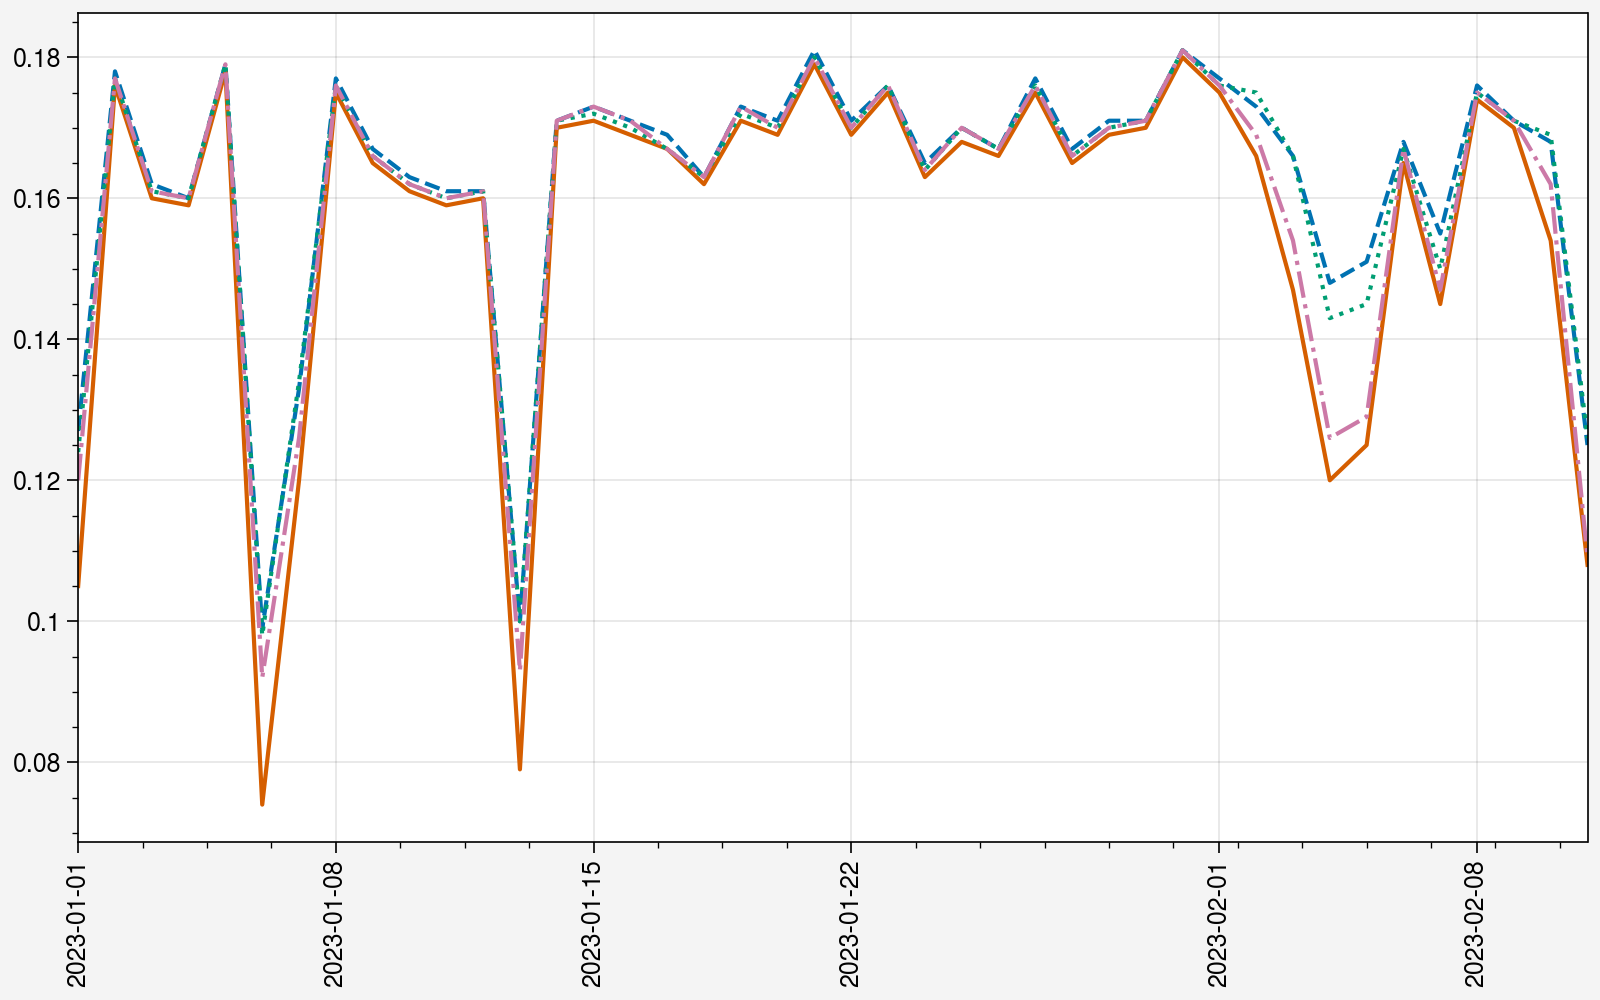

In [41]:
surface = po.get_surfaces()[1]
string = po.get_strings(surface)[0]
module = po.get_modules(surface,string)[0]


# fig, axe = pplt.subplots(ncols=2, nrows=1)

topo = 'micro_inverter'

a = po.get_tabular_results([surface,po.get_strings(surface)[0]],topology=topo,
                      analysis_period=None, rename_cols=False)[['eff']].resample('D').max()


b = po.get_tabular_results([surface,po.get_strings(surface)[1]],topology=topo,
                      analysis_period=None, rename_cols=False)[['eff']].resample('D').max()


c = po.get_tabular_results([surface,po.get_strings(surface)[2]],topology=topo,
                      analysis_period=None, rename_cols=False)[['eff']].resample('D').max()


d = po.get_tabular_results([surface,po.get_strings(surface)[3]],topology=topo,
                      analysis_period=None, rename_cols=False)[['eff']].resample('D').max()


fig,axes = pplt.subplots(ncols=1,nrows=1,figsize=(8,5))

ax = axes[0]

ax.line(a, linestyle='dashed', label='string_0')
ax.line(b, linestyle='solid', label='string_1')
ax.line(c, linestyle='dotted', label='string_2')
ax.line(d, linestyle='dashdot', label='string_3')



<AxesSubplot:>

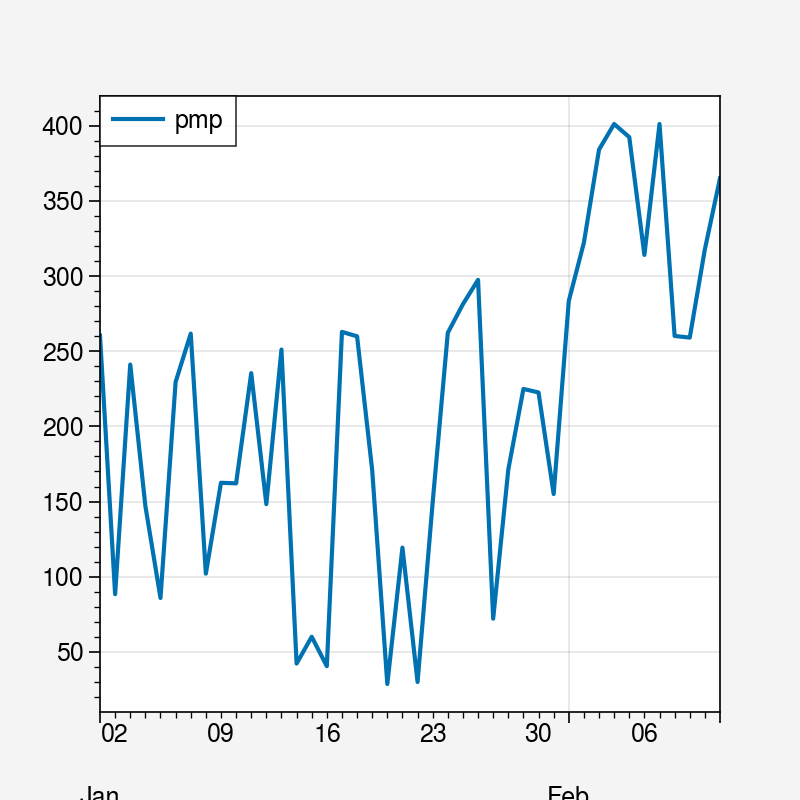

In [32]:
surface = po.get_surfaces()[1]
string = po.get_strings(surface)[0]
module = po.get_modules(surface,string)[0]

po.get_tabular_results([surface,string,module],topology='micro_inverter',
                      analysis_period=None, rename_cols=False)[['pmp']].resample('D').sum().plot()

In [141]:
modules = po.get_modules(surface,string)
timeseries = po.all_hoy

string_results = {"Imod":[],
                 "Vmod":[],
                 "Gmod":[],}

for module in modules:
    Imod = {}
    Vmod = {}
    Gmod = {}

    for hoy in timeseries:
        Imod.update({hoy:po.get_dict_instance([surface, string, module])['CURVES'][po.topology]['Imod']})
    
    string_results["Imod"].append(Imod)


## Single Process

In [ ]:

for topology in ['string_inverter', 'micro_inverter', 'central_inverter']:
    print(topology)
    po.topology = topology
    for surface in po.get_surfaces():
        po.reset_results_dict(surface)
        for hoy in tqdm(range(0,8760)):
            po.simulate_system(surface, hoy)
            
            po.write_first_level_results(surface, hoy) # topology dependent
        
        for string in po.get_strings(surface):
            if po.topology=='micro_inverter':
                po.write_up_string_results(surface, string)

        po.write_up_surface_results(surface)

    po.write_up_object_results()
        

In [ ]:

rename_cols = True
surface = po.get_surfaces()[0]
string = po.get_strings(surface)[0]
module = po.get_modules(surface, string)[0]
topology = 'micro_inverter'

analysis_period = time_utils.create_analysis_period(start_date = "01-01-2023-10:00",
                                                    end_date = "12-31-2023-23:00")

po.get_tabular_results([surface, string, module], topology, analysis_period, rename_cols=False)['pmp']

In [ ]:
1317284.155 / 1000

## Plots

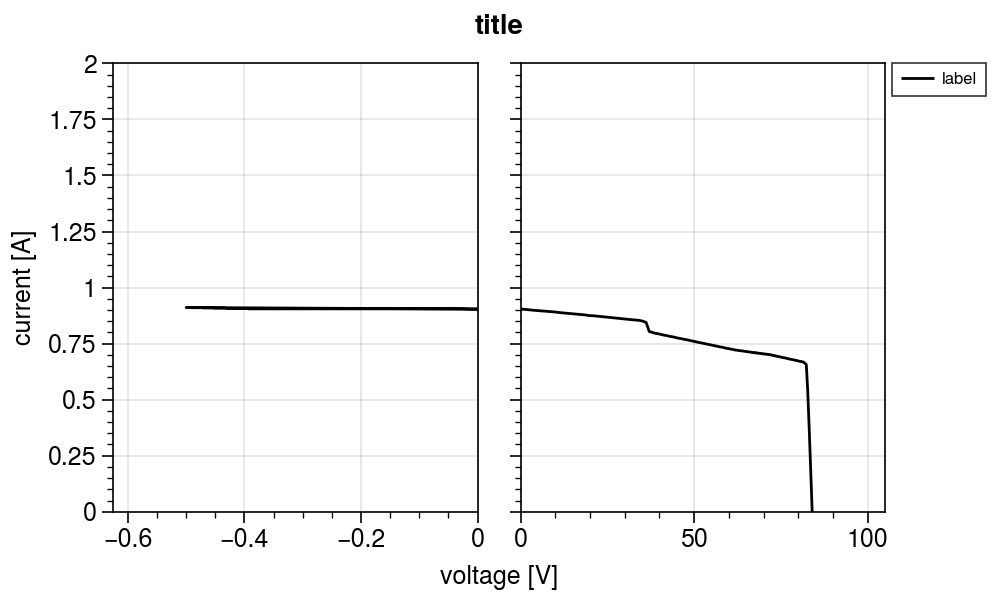

In [40]:

surface = po.get_surfaces()[0]
hoy = 12

i_l = po.get_dict_instance([surface,string,module])['CURVES']['micro_inverter']['Imod'][hoy]
v_l = po.get_dict_instance([surface,string,module])['CURVES']['micro_inverter']['Vmod'][hoy]

ipv_plots.plot_curves(i_l,
                      v_l,
                      po.cell.parameters_dict,
                      y_max=2)

In [ ]:
diode_number = 1
ipv_plots.plot_curves(sub_diode_curves_l[diode_number][0,:,:].tolist(),
                      sub_diode_curves_l[diode_number][1,:,:].tolist(),
                      po.cell.parameters_dict,
                      labels=None,
                      linewidth=0.5)

In [ ]:
ipv_plots.plot_curves(diode_i,
                      diode_v,
                      po.cell.parameters_dict,
                      labels=None,
                      linewidth=0.5,
                      colors=['red','blue','green'])

In [ ]:
ipv_plots.plot_curves(Imod,
                      Vmod,
                      po.cell.parameters_dict,
                      y_max=10)

# Create Dummy Profiles

In [ ]:
def create_sun_mask(file_path):
    sun = pd.read_csv(file_path,names=['HOY']) 
    if len(sun[sun['HOY']==range(1416, 1440)])>0:
        print('Leap days detected')
        
    sun_hours = np.floor(sun).astype(int)
    empty = pd.DataFrame(data={'HOY':list(range(0,8760))})
    def eval_sun_up(HOY,sun_up_list):
        if HOY in sun_up_list:
            return True
        else:
            return False

    sun_up = empty.apply(lambda x: eval_sun_up(x['HOY'],sun_hours['HOY'].tolist()),axis=1)
    sun_up = pd.DataFrame(sun_up).reset_index().rename(columns={"index":"HOY",0:"Sunny"})
    return sun_up, sun_hours


path = "total"
irrad_df_list_total = []
for m in [1,2,3,4,5,6,7,8,9,10,11,12]:
    month = str(m).zfill(2)
    sun_path = f"/Users/jmccarty/Data/220726_vegetation_paper/JuliusBar_2679_1249/hb_model/simulation_repo/cell_Wall2/month_{month}/no_trees/results/simulations/irradiance/annual_irradiance/results/{path}/sun-up-hours.txt"
    ill_path = f"/Users/jmccarty/Data/220726_vegetation_paper/JuliusBar_2679_1249/hb_model/simulation_repo/cell_Wall2/month_{month}/no_trees/results/simulations/irradiance/annual_irradiance/results/{path}/grid_cells_2679_1249_Wall2.ill"
    ill = pd.read_csv(ill_path, delimiter=' ', header=None).iloc[:, 1:].T.reset_index(drop=True)
    sun_up, sun_hours = create_sun_mask(sun_path)
    sun_ill = pd.concat([sun_hours,ill],axis=1)
    irrad_df = pd.merge(sun_up,sun_ill,how="left",on="HOY").fillna(0)
    del irrad_df['Sunny']
    del irrad_df['HOY']
    irrad_df_list_total.append(irrad_df)
    
irrad_df_total = sum(irrad_df_list_total)


path = "direct"
irrad_df_list_direct = []
for m in [1,2,3,4,5,6,7,8,9,10,11,12]:
    month = str(m).zfill(2)
    sun_path = f"/Users/jmccarty/Data/220726_vegetation_paper/JuliusBar_2679_1249/hb_model/simulation_repo/cell_Wall2/month_{month}/no_trees/results/simulations/irradiance/annual_irradiance/results/{path}/sun-up-hours.txt"
    ill_path = f"/Users/jmccarty/Data/220726_vegetation_paper/JuliusBar_2679_1249/hb_model/simulation_repo/cell_Wall2/month_{month}/no_trees/results/simulations/irradiance/annual_irradiance/results/{path}/grid_cells_2679_1249_Wall2.ill"
    ill = pd.read_csv(ill_path, delimiter=' ', header=None).iloc[:, 1:].T.reset_index(drop=True)
    sun_up, sun_hours = create_sun_mask(sun_path)
    sun_ill = pd.concat([sun_hours,ill],axis=1)
    irrad_df = pd.merge(sun_up,sun_ill,how="left",on="HOY").fillna(0)
    del irrad_df['Sunny']
    del irrad_df['HOY']
    irrad_df_list_direct.append(irrad_df)
    
irrad_df_direct = sum(irrad_df_list_direct)
irrad_df_diffuse = irrad_df_total-irrad_df_direct

In [ ]:
for stream in ['direct','diffuse']:

    if stream=='direct':
        irrad_df = irrad_df_direct
    elif stream=='diffuse':
        irrad_df = irrad_df_diffuse
        
    sample_A = list(irrad_df.sum(axis=0).sort_values(ascending=False)[0:25].index)
    sample_B = list(irrad_df.sum(axis=0).sort_values(ascending=True)[10890:10890+25].index)
    sample_C = list(irrad_df.sum(axis=0).sort_values(ascending=True)[7260:7260+25].index)
    sample_D = list(irrad_df.sum(axis=0).sort_values(ascending=True)[3630:3630+25].index)
    samples = utils.flatten_list([sample_A,sample_B,sample_C,sample_D])

    sample_df = pd.DataFrame(irrad_df[samples].to_numpy())
    sample_df.to_csv(f"/Users/jmccarty/Data/221205_ipv_workbench/github/IPV_Workbench/ipv_workbench/sample/irradiance_profiles_{stream}.csv",index=False)

In [ ]:
curves_isc = utils.calc_short_circuit(iv_curves)
max_currents = utils.calc_current_max(iv_curves,my_cell)


fig, axe = pplt.subplots(ncols=2,sharey=False,sharex=False)
series = circuits.calc_series(iv_curves,curves_isc,max_currents, bypass=False)
s = pd.DataFrame({'I':series[0],'V':series[1]})
s.sort_values(by='V')
axe[0].line(x=s['V'],y=s['I'])
axe[0].format(xlim=[-100,10],
              ylim=[-1,15])

series = circuits.calc_series(iv_curves,curves_isc,max_currents, bypass=True)
s = pd.DataFrame({'I':series[0],'V':series[1]})
s.sort_values(by='V')
axe[1].line(x=s['V'],y=s['I'])
axe[1].format(xlim=[-1,10],
              ylim=[-1,15])



In [ ]:
fig, axe = pplt.subplots(ncols=1,sharey=False,sharex=False)
parallel = circuits.calc_parallel(iv_curves)
s = pd.DataFrame({'I':parallel[0],'V':parallel[1]})
s = s.sort_values(by='V')
axe[0].line(x=s['V'],y=s['I'])
axe[0].format(xlim=[-20,2],
              ylim=[-1,40])


In [ ]:
my_cell.cell_plot_iv([1000,800,600,400,200,100],25,'First plot',mpp=False)

In [ ]:
my_module_null = devices.Module()
my_module_a = devices.Module()
my_module_b = devices.Module()

In [ ]:
my_module_a.cell = my_cell
my_module_b.cell = my_cell

In [ ]:
def open_panelizer_file(file_path):
    with open(file_path,"rb") as fp:
        panelized_object = pickle.load(fp)
    return panelized_object

# Archive

In [ ]:
conditions = utils.create_conditions_map()

simulation_results = {}

for n in range(0,len(conditions)):
    irrad = conditions[n][0]
    temp = conditions[n][1]
    key = f"{irrad},{temp}"
    simulation_results[key] = {"i":[],
                               "v":[]}
    results = ipv_sim.simulate_cell_curve(my_cell.parameters_dict,
                            irrad,
                            temp,
                            1000)
    results = np.array(results)
    simulation_results[key]['i'] = list(results[0,:])
    simulation_results[key]['v'] = list(results[1,:])

In [ ]:
iv_library_name = "/Users/jmccarty/Data/220723_iv_library/library/test_cell/test_gzip.gz"


json_str = json.dumps(simulation_results) + "\n"               # 2. string (i.e. JSON)
json_bytes = json_str.encode('utf-8')            # 3. bytes (i.e. UTF-8)

with gzip.open(iv_library_name, 'w') as fout:       # 4. fewer bytes (i.e. gzip)
    fout.write(json_bytes)    

In [ ]:
iv_library_name = "/Users/jmccarty/Data/220723_iv_library/library/test_cell/test_gzip.gz"

with gzip.open(iv_library_name, 'r') as fin:        # 4. gzip
    json_bytes = fin.read()                      # 3. bytes (i.e. UTF-8)

json_str = json_bytes.decode('utf-8')            # 2. string (i.e. JSON)
data = json.loads(json_str)                      # 1. data

In [ ]:

data = my_cell.iv_library
conditions = my_cell.iv_library_conditions
i_arrs = []
v_arrs = []
labels = []
for irrad, temp in [(800,20.01),(1000,25.0),(400,1.0)]:
    iv_key = utils.find_matching_key(data.keys(),conditions,irrad,temp)
    labels.append(iv_key)
    i_arrs.append(data[iv_key]['i'])
    v_arrs.append(data[iv_key]['v'])


# plot_curves(i_arrs, v_arrs, labels, 'no title', [1,2,3], ['k','blue','red'], ['solid','solid','solid'], fs=(5, 3),bypass=-5)
ipv_plots.plot_curves(i_arrs, v_arrs,
                    my_cell.parameters_dict,
                    labels=labels,
                    title='Test',
                    linewidth=1,
                    colors='red',
                    linestyle='solid',
                    fs=(5,3), 
                    bypass=True, 
                    mpp=True,
                    # y_max=12,
                    reverse=True,
                    # save='sample_iv_curve_cell_no_reverse.pdf'
                    )

# Investigate module

In [4]:
mod_df = pvlib.pvsystem.retrieve_sam("CECMod").transpose()
thin_df = mod_df[mod_df['Technology']=='Thin Film'].transpose()
cigs_df = mod_df[mod_df['Technology']=='CIGS'].transpose()
cdte_df = mod_df[mod_df['Technology']=='CdTe'].transpose()


In [409]:
param_dict = cigs_df['Miasole_FLEX_03_500W'].to_dict()
param_dict['breakdown_factor'] = 2e-3
param_dict['breakdown_exp'] = 3
param_dict['breakdown_voltage'] = -15
i,v = ipv_sim.solve_iv_curve(param_dict, np.array([1000,800,900]), np.array([10,15,12]))

# ipv_plots.plot_curves(i,v,param_dict,y_max=12)#,x_min=-10)

i.shape

(1000, 3)

In [ ]:
sum_i = np.sum(i,axis=1).shape
n_subcells = v.shape[1]

v[:,1]



In [568]:
mod_df.transpose()[[m for m in mod_df.index if "et_solar".lower() in m.lower()]].to_clipboard()

In [670]:
p = mod_df.transpose()[[m for m in mod_df.index if "bosch" in m.lower()]]['Bosch_Solar_Thin_Film_um_Si_plus_110']

In [23]:
p = mod_df.transpose()[[m for m in mod_df.index if "mia" in m.lower()]]['Miasole_FLEX_03_500W']
p = mod_df.transpose()[[m for m in mod_df.index if "Q_PEAK_DUO".lower() in m.lower()]]['Hanwha_Q_CELLS_Q_PEAK_DUO_G5_320']

Technology                 CIGS
Bifacial                      0
STC                       499.8
PTC                       438.1
A_c                        3.34
Length                      NaN
Width                       NaN
N_s                         112
I_sc_ref                    9.4
V_oc_ref                   74.8
I_mp_ref                   8.33
V_mp_ref                   60.0
alpha_sc               -0.00094
beta_oc               -0.185504
T_NOCT                     62.9
a_ref                  2.500625
I_L_ref                9.492962
I_o_ref                     0.0
R_s                    0.825987
R_sh_ref              83.520882
Adjust                -8.794698
gamma_r                  -0.312
BIPV                          Y
Version       SAM 2018.11.11 r2
Date                   1/3/2019
Name: Miasole_FLEX_03_500W, dtype: object

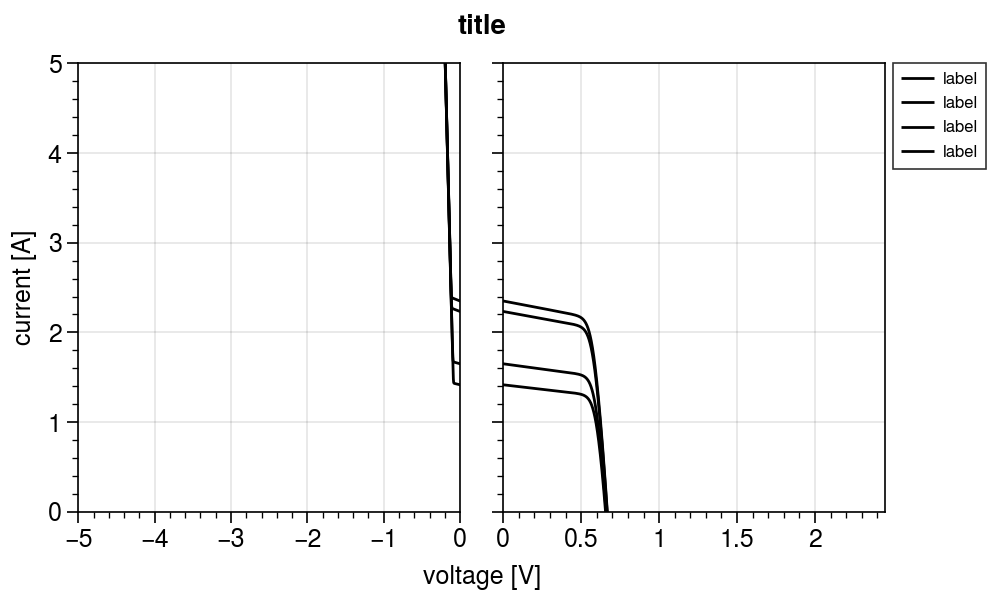

In [835]:
Geff = np.array([1000,700,950,600])
Tcell = np.array([25,25,25,25])

num_subcells = len(Tcell)

kwargs = {
        'breakdown_factor': 2e-3,
        'breakdown_exp': 3.28,
        'breakdown_voltage': -5.5,
    }

evaluated_module_voltages = np.linspace(0.99*kwargs['breakdown_voltage'],
                                        p['V_oc_ref'] * 1.1, 1000)

evaluated_cell_voltages = evaluated_module_voltages / p['N_s']

sde_args = np.vectorize(pvlib.pvsystem.calcparams_desoto)(Geff,
                                                         Tcell,
                                                         alpha_sc=p['alpha_sc'],
                                                         a_ref=p['a_ref'],
                                                         I_L_ref=p['I_L_ref'],
                                                         I_o_ref=p['I_o_ref'],
                                                         R_sh_ref=p['R_sh_ref'],
                                                         R_s=p['R_s'])
sde_args = np.array(sde_args)

i_subcell = []
v_subcell = []

for n in range(0,num_subcells):
    i_, v_, p_ = pvlib.singlediode.bishop88(evaluated_module_voltages, 
                                            *sde_args[:,n], 
                                            **kwargs
                                            )
    i_ = i_ / num_subcells
    v_ = v_ / p['N_s']
    i_subcell.append(i_)
    v_subcell.append(v_)
    
i_arr_subcell = np.array(i_subcell)
v_arr_subcell = np.array(v_subcell)
subcell_iv_curves = np.array([i_arr_subcell,v_arr_subcell])


# V = evaluated_module_voltages / parameters['N_s']

# subcell = circuits.calc_parallel(np.flipud(subcell_iv_curves))
ipv_plots.plot_curves(list(subcell_iv_curves[0,:,:]),
                      list(subcell_iv_curves[1,:,:]),
                      p,
                      y_max=5,
                      # labels=[str(t) for t in list(zip(Geff,Tcell))],
                      mpp=False,
                      x_min=-5
                     )

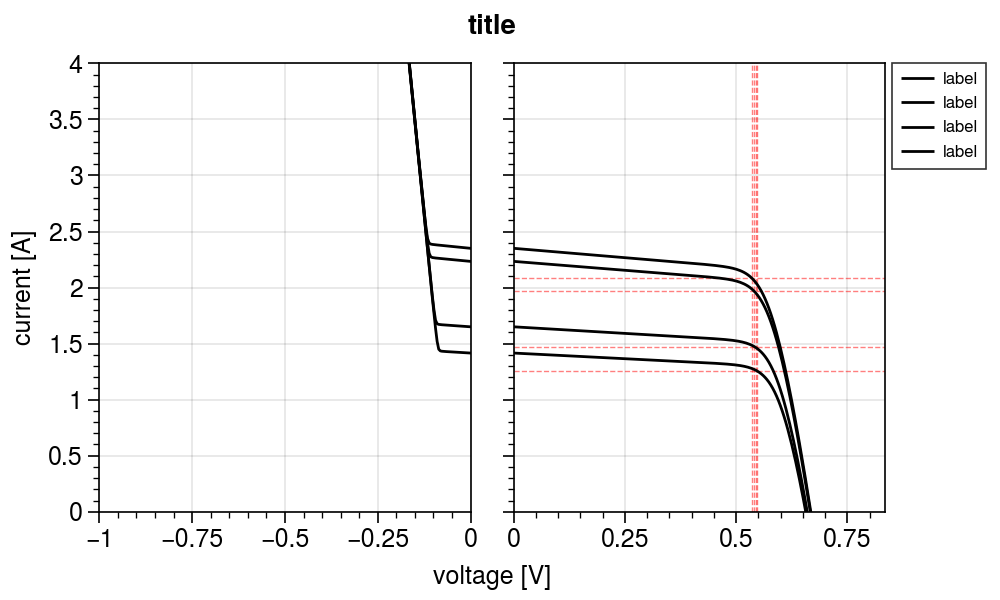

In [837]:
# we need a single voltage at which all of these currents can be evalauted to combine back into a single cell
# so for each one we extract 

Vmax_list = []
Vmin_list = []

for n in range(0,len(i_subcell)):
    i_c = np.array(i_subcell[n])
    v_c = np.array(v_subcell[n])
    i_max = np.max(i_c)
    # interpolate IV characteristic to find where V is 0
    # have ot flip (sort) I
    Vmax_list.append(np.interp(0,np.flipud(i_c),np.flipud(v_c))) # where Current is 0, Voltage is...
    Vmin_list.append(np.interp(i_max,np.flipud(i_c),np.flipud(v_c))) # where Current is Max, Voltage is...


Vmax = max(Vmax_list)
Vmin = min(Vmin_list)
V_range = np.linspace(Vmin,Vmax,1000)

new_i_list = []
for n in range(0,len(i_subcell)):
    i_c = np.array(i_subcell[n])
    v_c = np.array(v_subcell[n])
    new_i_list.append(np.interp(V_range,v_c,i_c))


ipv_plots.plot_curves(new_i_list+[np.sum(new_i_list,axis=0)],
                      [list(V_range)]*4,
                      p,
                      y_max=4,
                      # labels=[str(t) for t in list(zip(Geff,Tcell))],
                      mpp=True,
                      x_min=-1,
                      )

409.96401061176334


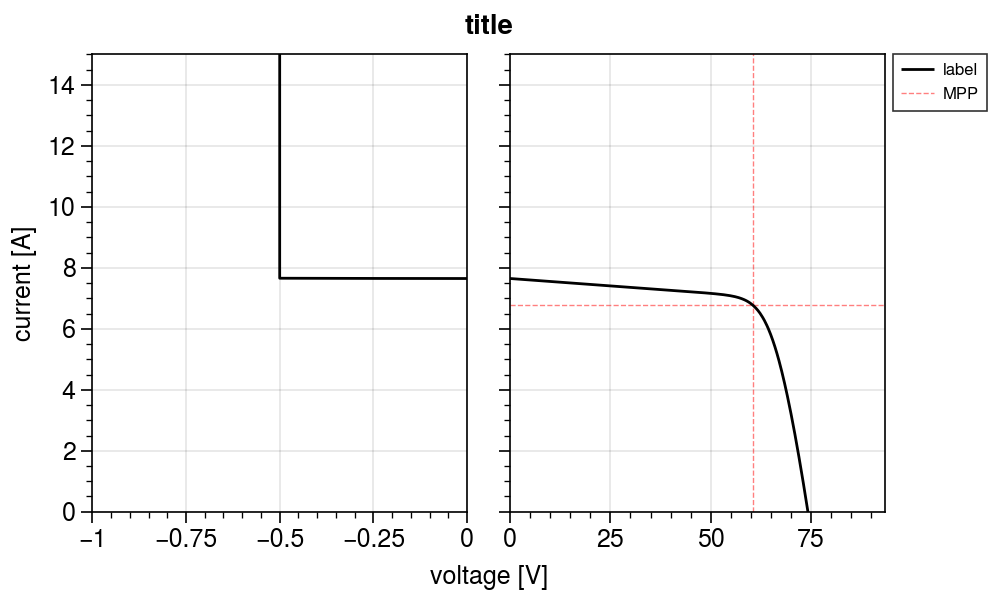

In [840]:
i_cell = np.sum(new_i_list,axis=0)
v_cell = V_range

all_iv_curves = np.array([np.array([i_cell]*p['N_s']),np.array([v_cell]*p['N_s'])])

module = circuits.calc_series(all_iv_curves,
                              kwargs['breakdown_voltage'],
                              diode_threshold=-0.5,
                              bypass=True)
print(max(module[0]*module[1]))
ipv_plots.plot_curves(module[0],
                      module[1],
                      p,
                      y_max=15,
                      # labels=[str(t) for t in list(zip(Geff,Tcell))],
                      mpp=True,
                      x_min=-1,
                      )

In [8]:

def read_map_excel(file_path):
    submodule_map = pd.read_excel(file_path,header=None,sheet_name='submodule').to_numpy().tolist()
    subdiode_map = pd.read_excel(file_path,header=None,sheet_name='subdiode').to_numpy().tolist()
    subcell_map = pd.read_excel(file_path,header=None,sheet_name='subcell').to_numpy().tolist()
    
    print(len(submodule_map))
    print(list(set([len(l) for l in submodule_map])))
    print(len(subdiode_map))
    print(list(set([len(l) for l in subdiode_map])))
    print(len(subcell_map))
    print(list(set([len(l) for l in subcell_map])))

    return submodule_map, subdiode_map, subcell_map
cigs_maps = "/Users/jmccarty/Desktop/miasole_maps.xlsx"
cigs_maps2 = "/Users/jmccarty/Desktop/miasole_maps 2.xlsx"
mono_maps = "/Users/jmccarty/Desktop/bano_simulations/resources/map_files/monocrystalline_portrait_maps.xlsx"
poly_maps = "/Users/jmccarty/Desktop/polycrystalline_maps.xlsx"
asi_maps = "/Users/jmccarty/Desktop/asi_map.xlsx"


p = mod_df.transpose()[[m for m in mod_df.index if "mia" in m.lower()]]['Miasole_FLEX_03_500W']
# p = mod_df.transpose()[[m for m in mod_df.index if "Q_PEAK_DUO".lower() in m.lower()]]['Hanwha_Q_CELLS_Q_PEAK_DUO_G5_320']


#### CIGS

In [572]:
p = mod_df.transpose()[[m for m in mod_df.index if "mia" in m.lower()]]['Miasole_FLEX_03_500W']
submodule_map, subdiode_map, subcell_map = read_map_excel(cigs_maps)

indexing_array = np.arange(0,112*4).reshape(112,4)

ncols = 1#6#1
nrows = 112#20#112

kwargs = {
        'breakdown_factor': 2e-3,
        'breakdown_exp': 3.28,
        'breakdown_voltage': -5.5,
    }

p['N_subcells'] = 4
p['diode_threshold'] = -0.5
for k, v in kwargs.items():
    p[k] = v

np.random.seed(42)
irrad_hoy_1 = np.random.rand(nrows,ncols)*1000
irrad_hoy_1 = np.ones((nrows,ncols))*1000
np.random.seed(2)
irrad_hoy_2 = np.random.rand(nrows,ncols)*1000
irrad_hoy_2 = np.ones((nrows,ncols))*1000
np.random.seed(300)
irrad_hoy_3 = np.random.rand(nrows,ncols)*1000
irrad_hoy_3 = np.ones((nrows,ncols))*1000
np.random.seed(77)
irrad_hoy_4 = np.random.rand(nrows,ncols)*1000
irrad_hoy_4 = np.ones((nrows,ncols))*1000

temp_hoy = np.array([[25]*p['N_subcells']*ncols]*nrows)
irrad_hoy = np.flipud(np.hstack([irrad_hoy_1,irrad_hoy_2,irrad_hoy_3,irrad_hoy_4]))
# irrad_hoy = irrad_hoy_1
# calculate_module_curve_v2
    
evaluated_module_voltages = np.linspace(0.99*kwargs['breakdown_voltage'],
                                        p['V_oc_ref'] * 1.1, 1000)
submodules = np.unique(submodule_map)
diodes = np.unique(subdiode_map)
subcells = np.unique(subcell_map)

submodule_i = []
submodule_v = []
for submodule_key in submodules:
    submodule_mask = submodule_map == submodule_key
    submodule_rowmask = submodule_mask.flatten()

    submodule_diode = np.array(subdiode_map)[submodule_rowmask, :]
    submodule_subcell = np.array(subcell_map)[submodule_rowmask, :]

    submodule_irrad = irrad_hoy[submodule_rowmask, :]
    submodule_temp = temp_hoy[submodule_rowmask, :]

    diode_i = []
    diode_v = []
    for diode_key in diodes:
        diode_mask = submodule_diode == diode_key
        diode_rowmask = diode_mask.flatten()

        submodule_subdiode_subcell = submodule_subcell[diode_rowmask, :]

        submodule_subdiode_irrad = submodule_irrad[diode_rowmask, :]
        submodule_subdiode_temp = submodule_temp[diode_rowmask, :]

        cells_i = []
        cells_v = []
        for subcell_key in np.unique(submodule_subdiode_subcell):
            submodule_subdiode_subcell_mask = submodule_subdiode_subcell == subcell_key
            submodule_subdiode_subcell_irrad = submodule_subdiode_irrad[submodule_subdiode_subcell_mask]
            submodule_subdiode_subcell_temp = submodule_subdiode_temp[submodule_subdiode_subcell_mask]

            Icell, Vcell = ipv_sim.solve_subcells(evaluated_module_voltages,
                                                  p,
                                                  submodule_subdiode_subcell_irrad,
                                                  submodule_subdiode_subcell_temp, ivcurve_pnts=1000)

            cells_i.append(Icell)
            cells_v.append(Vcell)

        sub_diode_curves = np.array([cells_i, cells_v])

        # sub_diode_curves = cell.retrieve_curves_multiple_cells(submodule_subdiode_irrad,
        #                                                              submodule_subdiode_temp)

        i, v = circuits.calc_series(sub_diode_curves,
                                    breakdown_voltage=p['breakdown_voltage'],
                                    diode_threshold=p['diode_threshold'],
                                    bypass=False)
        diode_i.append(i)
        diode_v.append(v)

    # calc series with bypass diodes to get submodule strings
    diode_curves = np.array([diode_i, diode_v])
    i, v = circuits.calc_series(diode_curves,
                                breakdown_voltage=p['breakdown_voltage'],
                                diode_threshold=p['diode_threshold'],
                                bypass=True)
    submodule_i.append(i)
    submodule_v.append(v)

# calc parallel connection of submodule strings to get module curves
submodule_curves = np.array([submodule_i, submodule_v])

# the parallel interpolation will work on lists of length 1 but can lead to weird results
# safer to just skip it if possible
if len(submodules)>1:
    Imod, Vmod = circuits.calc_parallel(submodule_curves)
else:
    Imod = submodule_i[0]
    Vmod = submodule_v[0]
Imod, Vmod


print(max(Imod*Vmod))
Imod.shape

112
[1]
112
[1]
112
[4]
499.72059632772937


(303,)

### Mono

In [ ]:
pvlib.pvsystem()

In [543]:
p = mod_df.transpose()[[m for m in mod_df.index if "peak" in m.lower()]]['Hanwha_Q_CELLS_Q_PEAK_DUO_G5_320']
submodule_map, subdiode_map, subcell_map = read_map_excel(mono_maps)

indexing_array = np.arange(0,112*4).reshape(112,4)

ncols = 6#1
nrows = 20#112

kwargs = {
        'breakdown_factor': 2e-3,
        'breakdown_exp': 3.28,
        'breakdown_voltage': -5.5,
        'diode_threshold': -0.5
    }

p['N_subcells'] = 1
p['N_s'] = p['N_s']
p['diode_threshold'] = -0.5
for k, v in kwargs.items():
    p[k] = v

np.random.seed(42)
irrad_hoy_1 = np.random.rand(nrows,ncols)*1000
irrad_hoy_1 = np.ones((nrows,ncols))*1000
np.random.seed(2)
irrad_hoy_2 = np.random.rand(nrows,ncols)*1000
irrad_hoy_2 = np.ones((nrows,ncols))*1000
np.random.seed(300)
irrad_hoy_3 = np.random.rand(nrows,ncols)*1000
irrad_hoy_3 = np.ones((nrows,ncols))*1000
np.random.seed(77)
irrad_hoy_4 = np.random.rand(nrows,ncols)*1000
irrad_hoy_4 = np.ones((nrows,ncols))*1000

temp_hoy = np.array([[25]*p['N_subcells']*ncols]*nrows)
irrad_hoy = irrad_hoy_4
# irrad_hoy = irrad_hoy_1
# calculate_module_curve_v2


submodules = np.unique(submodule_map)
diodes = np.unique(subdiode_map)
subcells = np.unique(subcell_map)

submodule_i = []
submodule_v = []
for submodule_key in submodules:
    submodule_mask = submodule_map == submodule_key
    
    submodule_diode = mask_nd(np.array(subdiode_map),submodule_mask)
    submodule_subcell = mask_nd(np.array(subcell_map),submodule_mask)
    
    submodule_irrad = mask_nd(irrad_hoy_1,submodule_mask)
    submodule_temp = mask_nd(temp_hoy,submodule_mask)

    diode_i = []
    diode_v = []
    for diode_key in diodes:
        diode_mask = submodule_diode == diode_key

        submodule_subdiode_subcell = mask_nd(submodule_subcell,diode_mask)
        
        submodule_subdiode_irrad = mask_nd(submodule_irrad,diode_mask)
        submodule_subdiode_temp = mask_nd(submodule_temp,diode_mask)   
        
        Icell, Vcell = ipv_sim.solve_cells(p,
                                           submodule_subdiode_irrad.flatten(),
                                           submodule_subdiode_temp.flatten())


        sub_diode_curves = np.array([Icell.T, Vcell.T])
        i, v = circuits.calc_series(sub_diode_curves,
                                    breakdown_voltage=p['breakdown_voltage'],
                                    diode_threshold=p['diode_threshold'],
                                    bypass=False)
        diode_i.append(i)
        diode_v.append(v)

    # calc series with bypass diodes to get submodule strings
    diode_curves = np.array([diode_i, diode_v])
    i, v = circuits.calc_series(diode_curves,
                                breakdown_voltage=p['breakdown_voltage'],
                                diode_threshold=p['diode_threshold'],
                                bypass=True)
    submodule_i.append(i)
    submodule_v.append(v)

# calc parallel connection of submodule strings to get module curves
submodule_curves = np.array([submodule_i, submodule_v])

# the parallel interpolation will work on lists of length 1 but can lead to weird results
# safer to just skip it if possible
if len(submodules)>1:
    Imod, Vmod = circuits.calc_parallel(submodule_curves)
else:
    Imod = submodule_i[0]
    Vmod = submodule_v[0]
Imod, Vmod


print(max(Imod*Vmod))
Imod.shape

20
[6]
20
[6]
20
[6]
319.8637342589547


(303,)

In [ ]:
mod_df.transpose()[[m for m in mod_df.index if "mia" in m.lower()]].to_clipboard()

### Check Functions

#### CIGS Old


112
[1]
112
[1]
112
[4]
8.315231010654866 60.10415603925025 499.77994216681265


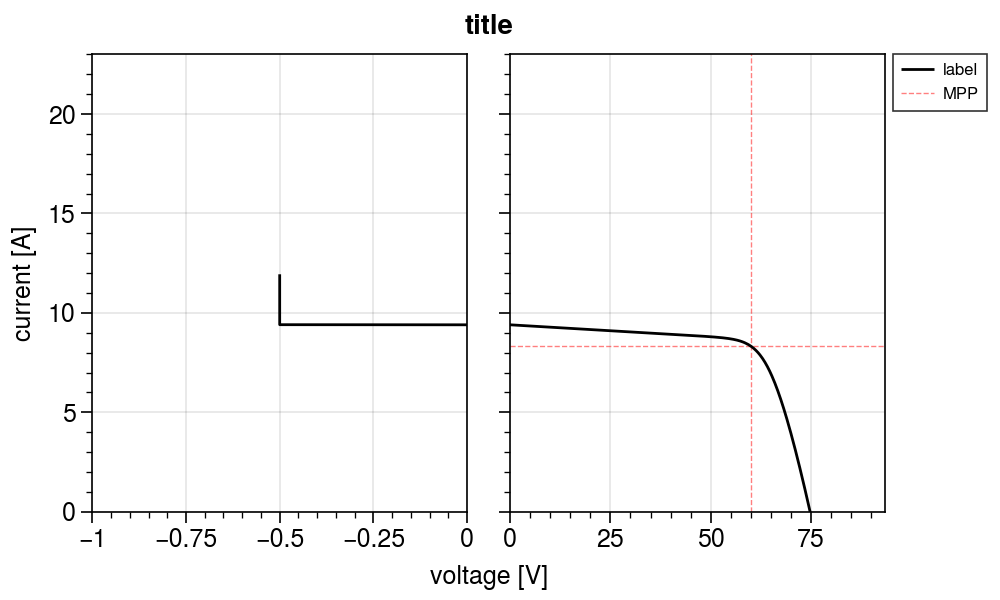

In [574]:
p = mod_df.transpose()[[m for m in mod_df.index if "mia" in m.lower()]]['Miasole_FLEX_03_500W']
submodule_map, subdiode_map, subcell_map = read_map_excel(cigs_maps)

indexing_array = np.arange(0,112*4).reshape(112,4)

ncols = 1#6#1
nrows = 112#20#112

kwargs = {
        'breakdown_factor': 2e-3,
        'breakdown_exp': 3.28,
        'breakdown_voltage': -5.5,
    }

p['N_subcells'] = 4
p['diode_threshold'] = -0.5
for k, v in kwargs.items():
    p[k] = v

np.random.seed(42)
irrad_hoy_1 = np.random.rand(nrows,ncols)*1000
irrad_hoy_1 = np.ones((nrows,ncols))*1000
np.random.seed(2)
irrad_hoy_2 = np.random.rand(nrows,ncols)*1000
irrad_hoy_2 = np.ones((nrows,ncols))*1000
np.random.seed(300)
irrad_hoy_3 = np.random.rand(nrows,ncols)*1000
irrad_hoy_3 = np.ones((nrows,ncols))*1000
np.random.seed(77)
irrad_hoy_4 = np.random.rand(nrows,ncols)*1000
irrad_hoy_4 = np.ones((nrows,ncols))*1000

temp_hoy = np.array([[25]*p['N_subcells']*ncols]*nrows)
irrad_hoy = np.flipud(np.hstack([irrad_hoy_1,irrad_hoy_2,irrad_hoy_3,irrad_hoy_4]))


Imod, Vmod = ipv_calc.calculate_module_curve_single_column(irrad_hoy,temp_hoy,p,submodule_map,subdiode_map,subcell_map)
Pmod = Imod*Vmod
print(Imod[np.argmax(Pmod)],Vmod[np.argmax(Pmod)],np.max(Pmod))
ipv_plots.plot_curves(Imod,
                      Vmod,
                      p,
                      y_max=23,
                      # labels=[str(t) for t in list(zip(Geff,Tcell))],
                      mpp=True,
                      x_min=-1,
                      )

#### CIGS

In [593]:
p

Technology                        CIGS
Bifacial                             0
STC                            319.935
PTC                              277.6
A_c                               2.22
Length                             NaN
Width                              NaN
N_s                                144
I_sc_ref                           9.4
V_oc_ref                          48.0
I_mp_ref                          8.31
V_mp_ref                          38.5
alpha_sc                     -0.000658
beta_oc                        -0.1704
T_NOCT                            49.1
a_ref                         2.100646
I_L_ref                       9.462353
I_o_ref                            0.0
R_s                           0.401913
R_sh_ref                     60.590122
Adjust                       12.382133
gamma_r                         -0.519
BIPV                                 N
Version              SAM 2018.11.11 r2
Date                          1/3/2019
N_subcells               

36
[4]
36
[4]
0
[]
8.300643256679537 38.54101599111776 319.9152244922498


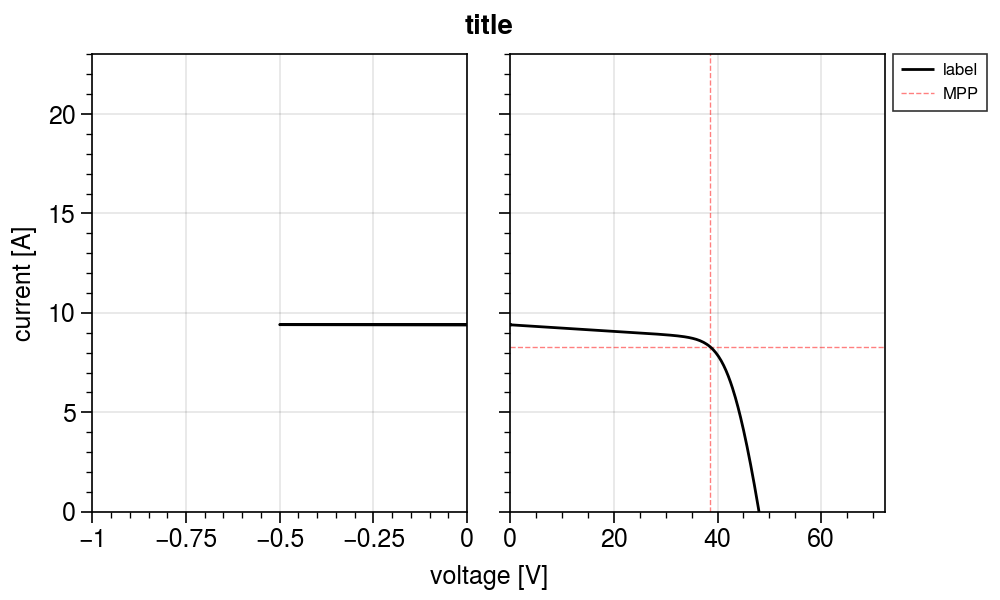

In [594]:
p = mod_df.transpose()[[m for m in mod_df.index if "mia" in m.lower()]]['Miasole_FLEX_03_320W']
submodule_map, subdiode_map, subcell_map = read_map_excel(cigs_maps2)

ncols = 4#1
nrows = 36#112

kwargs = {
        'breakdown_factor': 2e-3,
        'breakdown_exp': 3.28,
        'breakdown_voltage': -5.5,
    }

p['N_subcells'] = 1
p['N_p'] = 2
p['N_s'] = 72
p['diode_threshold'] = -0.5
for k, v in kwargs.items():
    p[k] = v


irrad_hoy = np.ones((nrows,ncols))*1000
temp_hoy = np.array([[25]*p['N_subcells']*ncols]*nrows)

Imod, Vmod = ipv_calc.calculate_module_curve_multiple_column(irrad_hoy,temp_hoy,p,submodule_map,subdiode_map)
Pmod = Imod*Vmod
print(Imod[np.argmax(Pmod)],Vmod[np.argmax(Pmod)],np.max(Pmod))
ipv_plots.plot_curves(Imod,
                      Vmod,
                      p,
                      y_max=23,
                      # labels=[str(t) for t in list(zip(Geff,Tcell))],
                      mpp=True,
                      x_min=-1,
                      )

#### Mono

In [10]:
irrad_hoy.shape

(20, 6)

In [11]:
temp_hoy.shape

(20, 6)

In [16]:
temp_hoy

array([[25, 25, 25, 25, 25, 25],
       [25, 25, 25, 25, 25, 25],
       [25, 25, 25, 25, 25, 25],
       [25, 25, 25, 25, 25, 25],
       [25, 25, 25, 25, 25, 25],
       [25, 25, 25, 25, 25, 25],
       [25, 25, 25, 25, 25, 25],
       [25, 25, 25, 25, 25, 25],
       [25, 25, 25, 25, 25, 25],
       [25, 25, 25, 25, 25, 25],
       [25, 25, 25, 25, 25, 25],
       [25, 25, 25, 25, 25, 25],
       [25, 25, 25, 25, 25, 25],
       [25, 25, 25, 25, 25, 25],
       [25, 25, 25, 25, 25, 25],
       [25, 25, 25, 25, 25, 25],
       [25, 25, 25, 25, 25, 25],
       [25, 25, 25, 25, 25, 25],
       [25, 25, 25, 25, 25, 25],
       [25, 25, 25, 25, 25, 25]])

(20, 6)

20
[6]
20
[6]
20
[6]
9.490876848035745 33.72249795958657 320.0560751425728


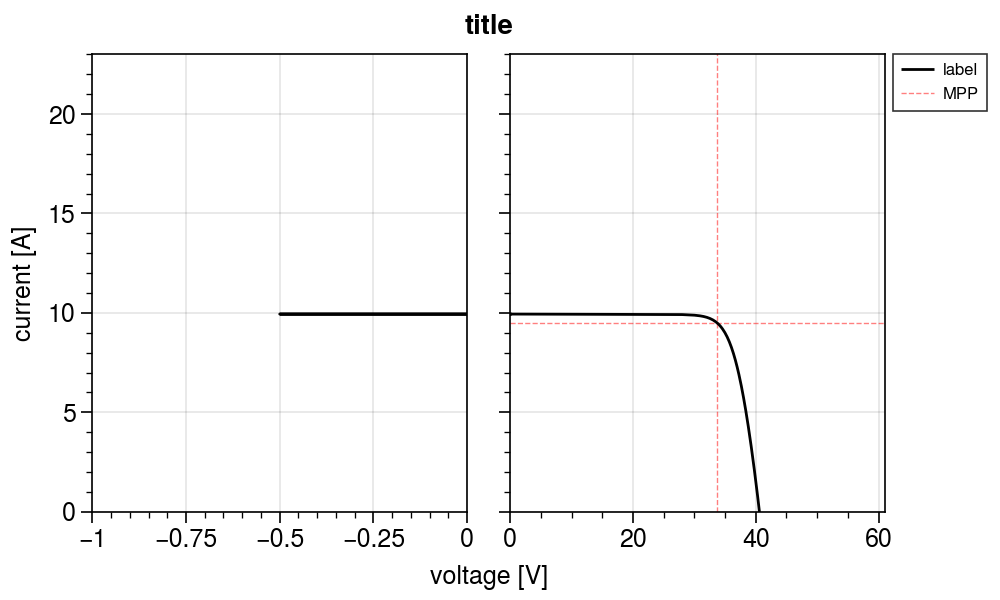

In [9]:
p = mod_df.transpose()[[m for m in mod_df.index if "peak" in m.lower()]]['Hanwha_Q_CELLS_Q_PEAK_DUO_BLK_G5_SC_320']
submodule_map, subdiode_map, subcell_map = read_map_excel(mono_maps)

ncols = 6#1
nrows = 20#112

kwargs = {
        'breakdown_factor': 2e-3,
        'breakdown_exp': 3.28,
        'breakdown_voltage': -5.5,
    }

p['N_subcells'] = 1
p['N_p'] = 2
# p['N_s'] = p['N_s'] / 2
p['diode_threshold'] = -0.5
for k, v in kwargs.items():
    p[k] = v


irrad_hoy = np.ones((nrows,ncols))*1000
temp_hoy = np.array([[25]*p['N_subcells']*ncols]*nrows)

Imod, Vmod = ipv_calc.calculate_module_curve_multiple_column(irrad_hoy,temp_hoy,p,submodule_map,subdiode_map)
Pmod = Imod*Vmod
print(Imod[np.argmax(Pmod)],Vmod[np.argmax(Pmod)],np.max(Pmod))
ipv_plots.plot_curves(Imod,
                      Vmod,
                      p,
                      y_max=23,
                      # labels=[str(t) for t in list(zip(Geff,Tcell))],
                      mpp=True,
                      x_min=-1,
                      )

#### Poly

In [603]:
p

Technology                  Multi-c-Si
Bifacial                             0
STC                             320.32
PTC                              288.9
A_c                              1.956
Length                            1.96
Width                            0.998
N_s                                 60
I_sc_ref                           9.0
V_oc_ref                          45.7
I_mp_ref                           8.8
V_mp_ref                          36.4
alpha_sc                      0.004381
beta_oc                      -0.142936
T_NOCT                            46.5
a_ref                         1.854949
I_L_ref                       9.373078
I_o_ref                            0.0
R_s                           0.440245
R_sh_ref                    539.486206
Adjust                       10.322333
gamma_r                      -0.440234
BIPV                                 N
Version              SAM 2018.11.11 r2
Date                          1/3/2019
N_subcells               

12
[6]
12
[6]
12
[6]
8.789089570686546 36.44467660453165 320.3155270519331


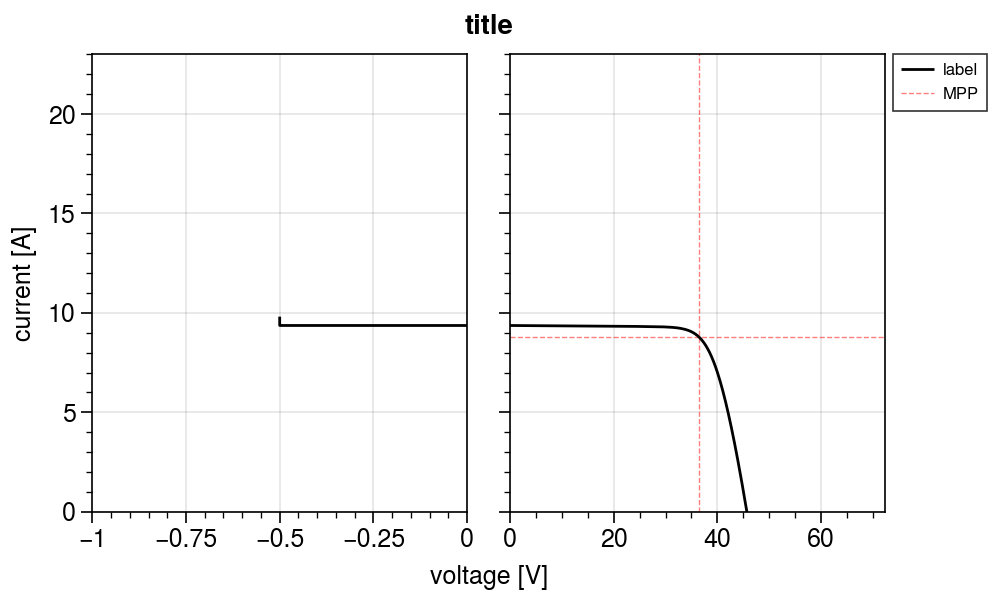

In [604]:
p = mod_df.transpose()[[m for m in mod_df.index if "hyundai".lower() in m.lower()]]['Hyundai_Heavy_Industries_Green_Energy_Co__HiS_M320TI']
submodule_map, subdiode_map, subcell_map = read_map_excel(poly_maps)

ncols = 6#1
nrows = 12#112

kwargs = {
        'breakdown_factor': 2e-3,
        'breakdown_exp': 3.28,
        'breakdown_voltage': -5.5,
    }

p['N_subcells'] = 1
p['N_p'] = 1
p['N_s'] = 72
p['diode_threshold'] = -0.5
for k, v in kwargs.items():
    p[k] = v


irrad_hoy = np.ones((nrows,ncols))*1000
temp_hoy = np.array([[25]*p['N_subcells']*ncols]*nrows)

Imod, Vmod = ipv_calc.calculate_module_curve_multiple_column(irrad_hoy,temp_hoy,p,submodule_map,subdiode_map)
Pmod = Imod*Vmod
print(Imod[np.argmax(Pmod)],Vmod[np.argmax(Pmod)],np.max(Pmod))
ipv_plots.plot_curves(Imod,
                      Vmod,
                      p,
                      y_max=23,
                      # labels=[str(t) for t in list(zip(Geff,Tcell))],
                      mpp=True,
                      x_min=-1,
                      )

#### a-Si

In [609]:
p = mod_df.transpose()[[m for m in mod_df.index if "du_pont".lower() in m.lower()]]['Du_Pont_Apollo_DA136_C2']

1
[119]
1
[119]
10
[119]
1.0991554272213826 123.59309580954826 135.84802202615728


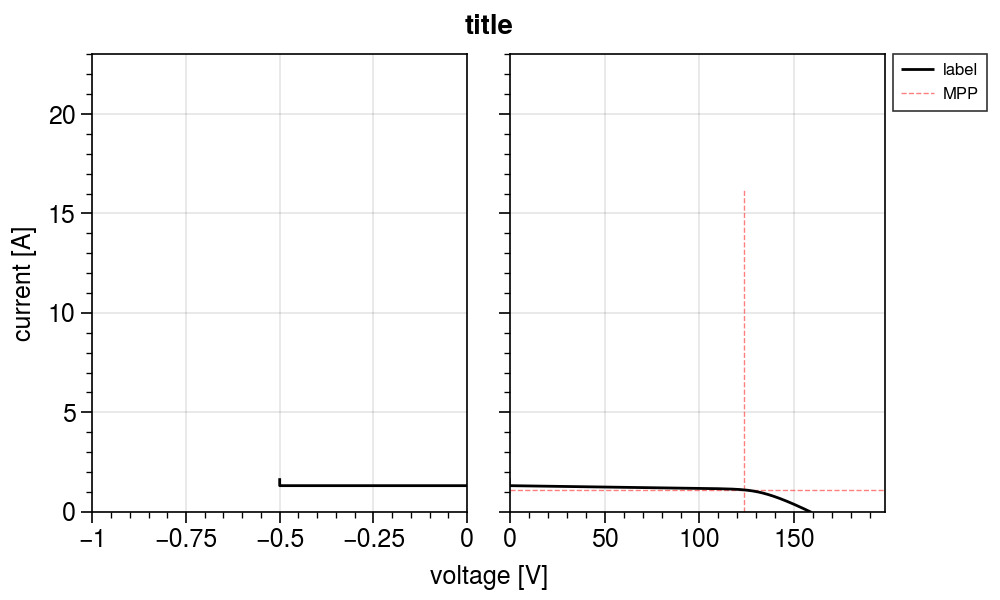

In [643]:
p = mod_df.transpose()[[m for m in mod_df.index if "du_pont".lower() in m.lower()]]['Du_Pont_Apollo_DA136_C2']
submodule_map, subdiode_map, subcell_map = read_map_excel(asi_maps)

ncols = 119#6#1
nrows = 1#20#112
kwargs = {
        'breakdown_factor': 2e-3,
        'breakdown_exp': 3.28,
        'breakdown_voltage': -5.5,
    }

p['N_subcells'] = 10
p['N_p'] = 1
p['N_s'] = 119
p['diode_threshold'] = -0.5
for k, v in kwargs.items():
    p[k] = v

np.random.seed(42)
irrad_hoy_1 = np.random.rand(nrows,ncols)*1000
irrad_hoy_1 = np.ones((nrows,ncols))*1000
np.random.seed(2)
irrad_hoy_2 = np.random.rand(nrows,ncols)*1000
irrad_hoy_2 = np.ones((nrows,ncols))*1000
np.random.seed(300)
irrad_hoy_3 = np.random.rand(nrows,ncols)*1000
irrad_hoy_3 = np.ones((nrows,ncols))*1000
np.random.seed(77)
irrad_hoy_4 = np.random.rand(nrows,ncols)*1000
irrad_hoy_4 = np.ones((nrows,ncols))*1000

temp_hoy = np.vstack([np.ones((nrows,ncols))*25 for n in range(0,p['N_subcells'])])
irrad_hoy = np.vstack([np.ones((nrows,ncols))*1000 for n in range(0,p['N_subcells'])])


Imod, Vmod = ipv_calc.calculate_module_curve_single_row(irrad_hoy,temp_hoy,p,submodule_map,subdiode_map,subcell_map)
Pmod = Imod*Vmod
print(Imod[np.argmax(Pmod)],Vmod[np.argmax(Pmod)],np.max(Pmod))
ipv_plots.plot_curves(Imod,
                      Vmod,
                      p,
                      y_max=23,
                      # labels=[str(t) for t in list(zip(Geff,Tcell))],
                      mpp=True,
                      x_min=-1,
                      )